# Student Performance Dataset Analysis - ANN
### Mehmet Emin Titrek - 2018300231

---
## Importing necessary libraries

In [1]:
library(data.table)
library(tidyverse)
library(GGally)
library(neuralnet)
library(NeuralNetTools)
library(ggplot2)
library(caret)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()

---
## Loading dataset

In [2]:
data_url <- 'https://raw.githubusercontent.com/MeminT99/ad455/main/assignment-11/Student_Performance.csv'
student_data <- fread(data_url)
names(student_data) <- gsub(" ", "_", names(student_data))

str(student_data)

Classes ‘data.table’ and 'data.frame':	10000 obs. of  6 variables:
 $ Hours_Studied                   : int  7 4 8 5 7 3 7 8 5 4 ...
 $ Previous_Scores                 : int  99 82 51 52 75 78 73 45 77 89 ...
 $ Extracurricular_Activities      : chr  "Yes" "No" "Yes" "Yes" ...
 $ Sleep_Hours                     : int  9 4 7 5 8 9 5 4 8 4 ...
 $ Sample_Question_Papers_Practiced: int  1 2 2 2 5 6 6 6 2 0 ...
 $ Performance_Index               : num  91 65 45 36 66 61 63 42 61 69 ...
 - attr(*, ".internal.selfref")=<externalptr> 


- **Hours Studied:** The total number of hours spent studying by each student.
- **Previous Scores:** The scores obtained by students in previous tests.
- **Extracurricular Activities:** Whether the student participates in extracurricular activities (Yes or No).
- **Sleep Hours:** The average number of hours of sleep the student had per day.
- **Sample Question Papers Practiced:** The number of sample question papers the student practiced.

---
## Explore and prepare the data

In [3]:
missing_raw <- student_data %>%
  summarise_all(~ sum(is.na(.) | . == ""))

missing_raw

Hours_Studied,Previous_Scores,Extracurricular_Activities,Sleep_Hours,Sample_Question_Papers_Practiced,Performance_Index
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


**Luckily, we do not have missing values in the data!!!**

In [4]:
## Apply function to calculate number of unique elements in each column
sapply(student_data, function(x) length(unique(x)))

Hours_Studied                  Previous_Scores 
                               9                               60 
      Extracurricular_Activities                      Sleep_Hours 
                               2                                6 
Sample_Question_Papers_Practiced                Performance_Index 
                              10                               91

In [5]:
set.seed(455)
dt <- student_data %>%
  mutate(Extracurricular_Activities = as.factor(ifelse(Extracurricular_Activities == 'Yes', 1, 0)),
         Performance_Category = as.factor(ifelse(Performance_Index >= 70, 1, 0))) %>%
  mutate(across(where(is.numeric), scale)) %>%
  sample_n(400)

- Converted Extracurricular_Activities column to binary factor: 1 for participation ('Yes'), 0 otherwise.
- Created Performance_Category column based on Performance_Index: 1 if Performance_Index is greater than or equal to 70, else 0.
- Normalized all numeric features.
- Take a 400 vars sample from data to decrease time that takes to build model!

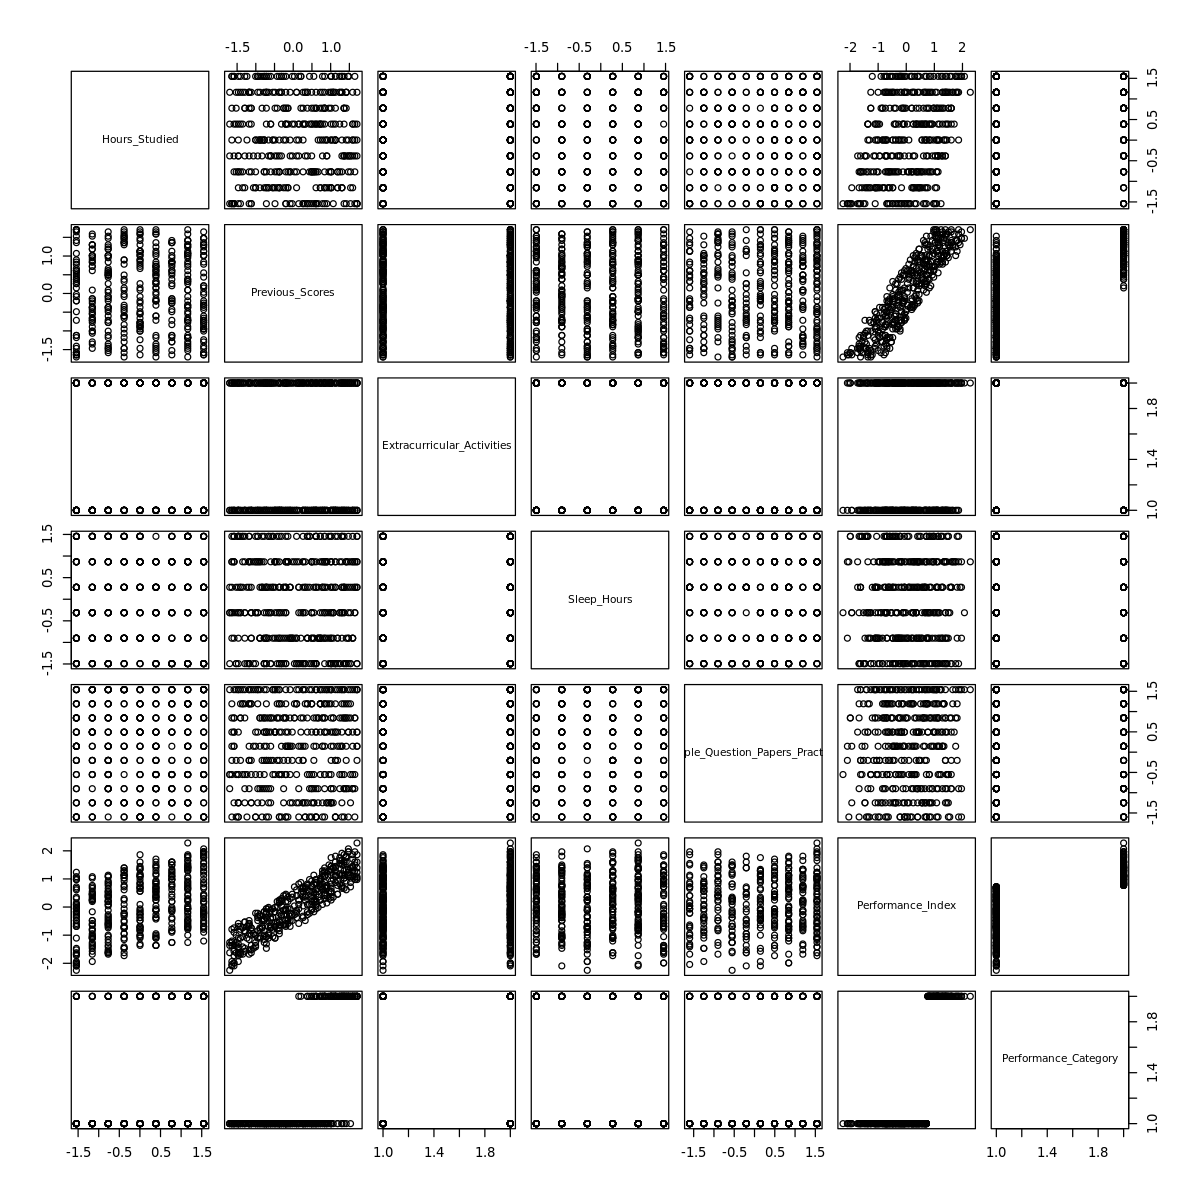

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)

pairs(dt)

In [7]:
dt[,-c(3,7)] %>% sapply(quantile, na.rm = T) %>% t()

,0%,25%,50%,75%,100%
Hours_Studied,-1.542072,-0.7696649,0.002742045,1.1613524,1.547556
Previous_Scores,-1.697829,-0.7320296,0.118450208,0.9545151,1.704090
Sleep_Hours,-1.492220,-0.9025493,0.276791230,0.8664615,1.456132
Sample_Question_Papers_Practiced,-1.598446,-0.6393713,0.145325936,1.1915890,1.540343
Performance_Index,-2.249820,-0.6883415,0.092397900,0.8731373,2.278468


## ANN for numeric prediction

In [8]:
set.seed(455)
train_indices <- dt[,sample(.I, 0.75 * .N)]

dt$Extracurricular_Activities <- as.integer(dt$Extracurricular_Activities)
dt$Performance_Category <- as.integer(dt$Performance_Category)

dt_train <- dt[train_indices]
dt_test <- dt[-train_indices]

### Train a model

In [9]:
formula1 <- reformulate(names(dt_train)[1:5], names(dt_train)[6])
formula1

Performance_Index ~ Hours_Studied + Previous_Scores + Extracurricular_Activities + 
    Sleep_Hours + Sample_Question_Papers_Practiced

In [10]:
dt_model <- neuralnet::neuralnet(formula1, data = dt_train, stepmax = 1e+15)

dt_model$result.matrix

error,1.499390e+00
reached.threshold,9.564910e-03
steps,6.109700e+04
Intercept.to.1layhid1,-2.220694e-02
Hours_Studied.to.1layhid1,1.303827e-01
Previous_Scores.to.1layhid1,3.122235e-01
Extracurricular_Activities.to.1layhid1,8.102528e-03
Sleep_Hours.to.1layhid1,1.404815e-02
Sample_Question_Papers_Practiced.to.1layhid1,9.544273e-03
Intercept.to.Performance_Index,-5.951612e+00
1layhid1.to.Performance_Index,1.195256e+01


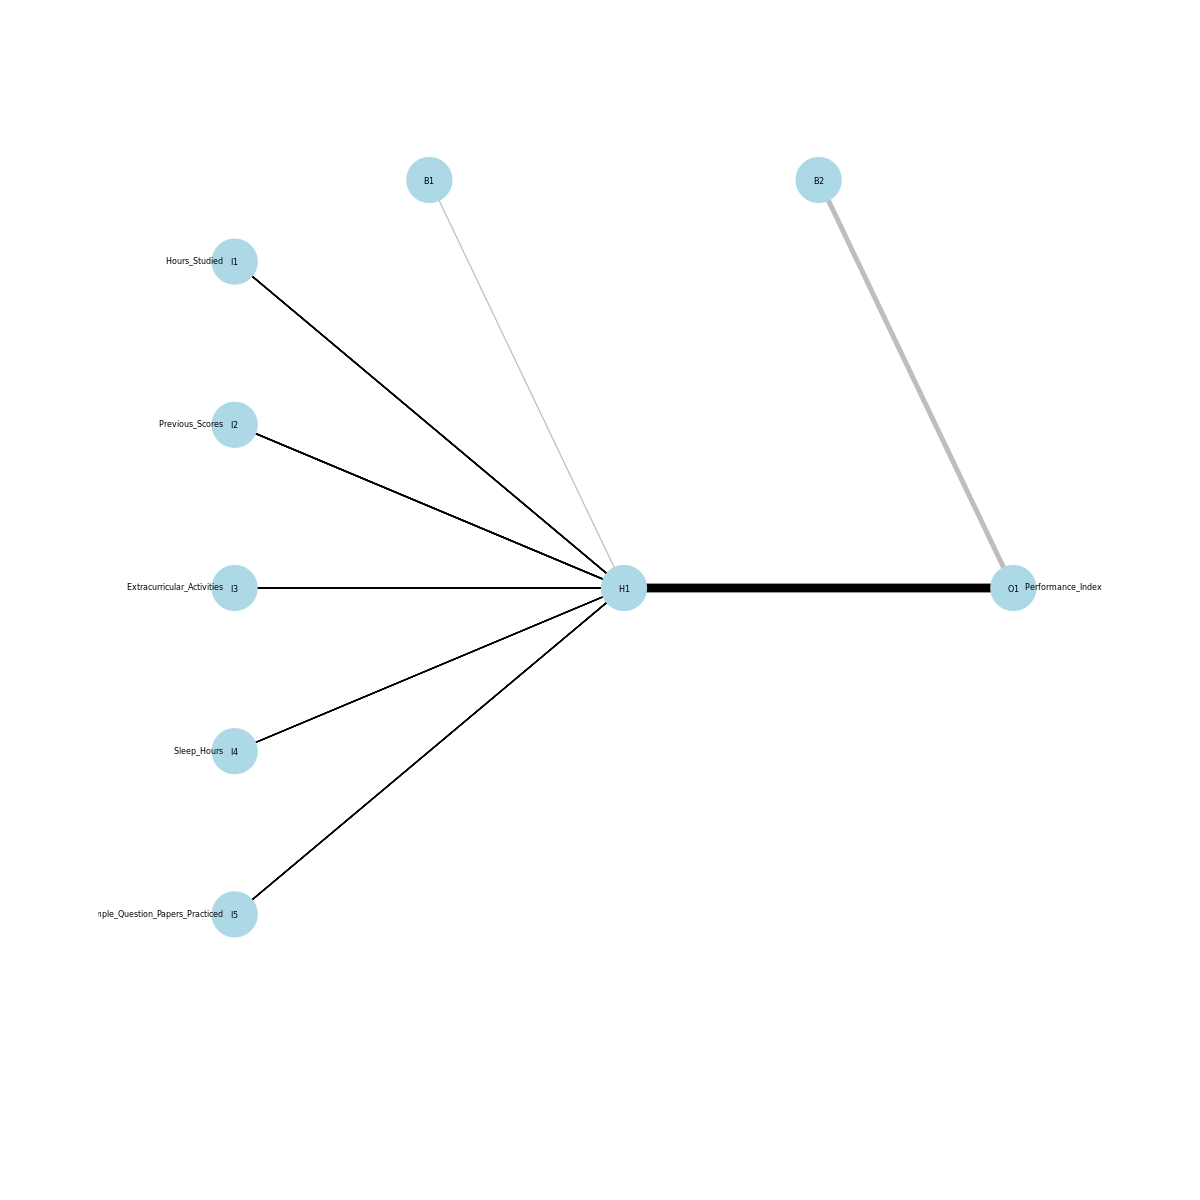

In [11]:
NeuralNetTools::plotnet(dt_model, cex_val = 0.4, line_stag = 0)

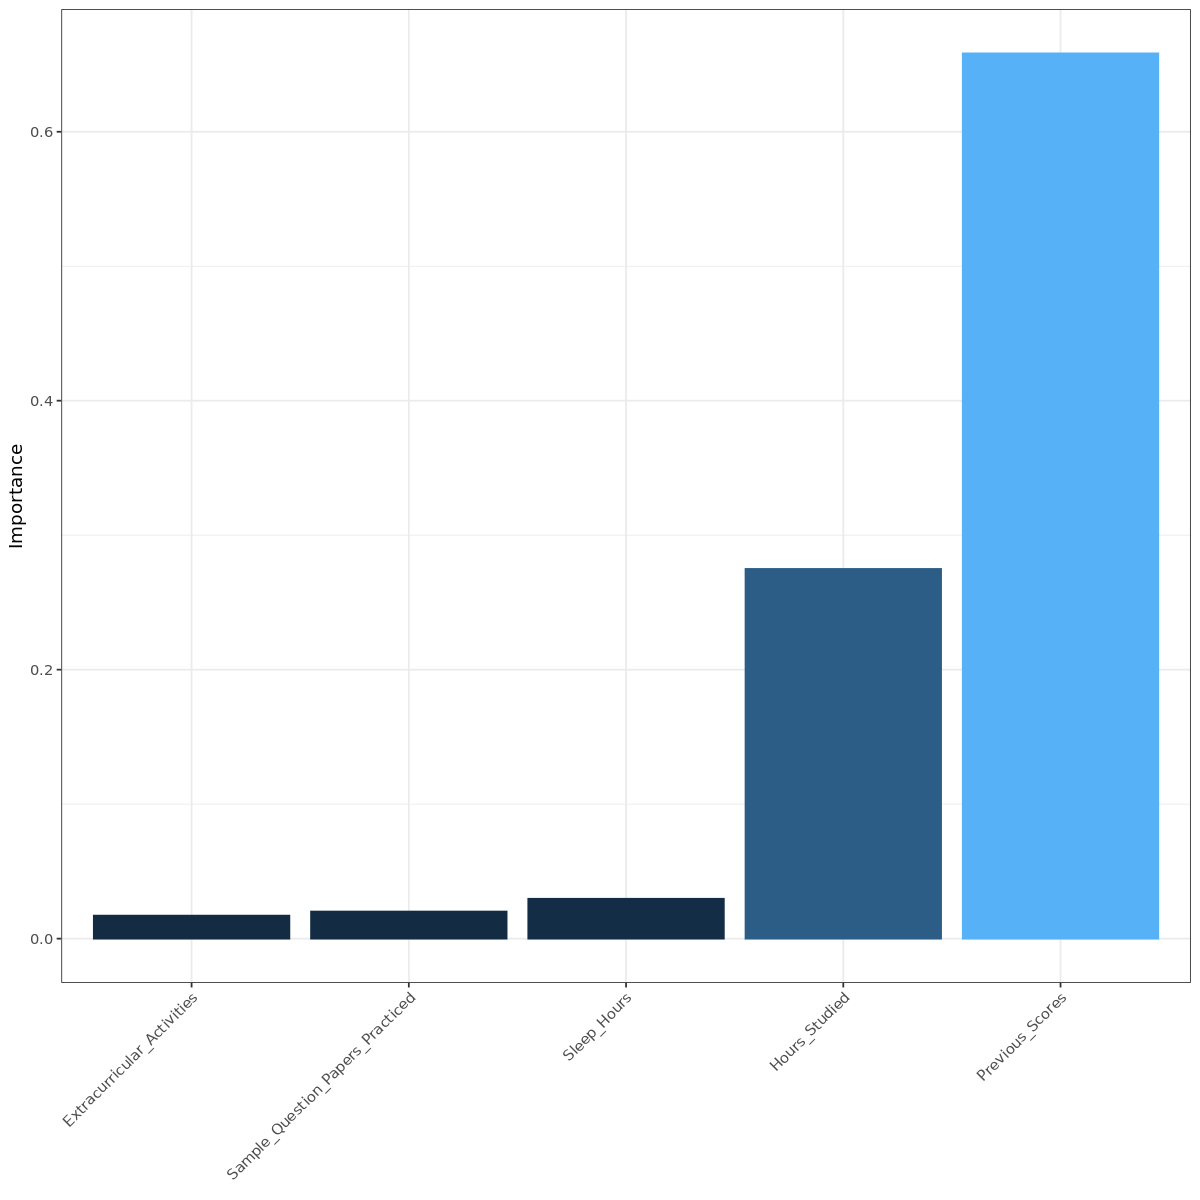

In [12]:
NeuralNetTools::garson(dt_model) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [13]:
NeuralNetTools::neuralweights(dt_model)

$struct
[1] 5 1 1

$wts
$wts$`hidden 1 1`
[1] -0.022206944  0.130382692  0.312223483  0.008102528  0.014048151
[6]  0.009544273

$wts$`out 1`
[1] -5.951612 11.952560

### Evaluate model performance

In [14]:
dt_pred <- neuralnet::compute(dt_model, dt_test[,c(1:5)])

In [15]:
dt_pred

,Hours_Studied,Previous_Scores,Extracurricular_Activities,Sleep_Hours,Sample_Question_Papers_Practiced
1,0.002742045,1.12749399,1,0.8664615,-1.5984458
1,-1.542071771,0.89685541,1,0.8664615,1.1915890
1,-0.769664863,1.18515364,2,-0.9025493,0.4940803
1,0.388945498,0.60855719,2,-1.4922196,0.8428346
1,-1.542071771,-0.71761464,1,-1.4922196,0.4940803
1,0.388945498,-1.17889180,2,0.8664615,-0.2034284
1,0.775148952,-0.25633748,1,-0.3128791,0.8428346
1,-0.383461409,-0.94825322,1,-0.3128791,1.5403433
1,1.161352406,1.06983435,2,-0.3128791,-1.2496914
1,-0.769664863,-1.52484967,1,-1.4922196,1.5403433


In [16]:
cor(dt_pred$net.result, dt_test$Performance_Index)

0.9954745


## ANN for classification

In [17]:
set.seed(455)
train_indices <- dt[,sample(.I, 0.75 * .N)]

dt$High <- ifelse(dt$Performance_Category == 2, 1, 0)
dt$Low <- ifelse(dt$Performance_Category == 1, 1, 0)
dt <- subset(dt, select = -c(Performance_Category))
dt$Extracurricular_Activities <- as.numeric(dt$Extracurricular_Activities)
dt$Performance_Category <- as.numeric(dt$Performance_Category)

dt_train <- dt[train_indices]
dt_test <- dt[-train_indices]

### Train a model

In [18]:
formula2 <- paste(paste(names(dt_train)[7:8], collapse = " + "),
                  paste(names(dt_train)[1:5], collapse = " + "),
                  sep = " ~ ") %>% as.formula

formula2

High + Low ~ Hours_Studied + Previous_Scores + Extracurricular_Activities + 
    Sleep_Hours + Sample_Question_Papers_Practiced
<environment: 0x55b9e118ee58>

In [19]:
nn_single <- neuralnet::neuralnet(formula2,
                                 data = dt_train,
                                 linear.output = F,
                                 lifesign = "full")

hidden: 1    thresh: 0.01    rep: 1/1    steps: 
   1000	min thresh: 0.0473386146728534
                                                
   2000	min thresh: 0.0473386146728534
                                                
   3000	min thresh: 0.0384240727815524
                                                
   4000	min thresh: 0.0365870556765682
                                                
   5000	min thresh: 0.02669536222411
                                                
   6000	min thresh: 0.02669536222411
                                                
   7000	min thresh: 0.0205374168900496
                                                
   8000	min thresh: 0.0196261450730555
                                                
   9000	min thresh: 0.0196261450730555
                                                
  10000	min thresh: 0.0177679804722088
                                                
  11000	min thresh: 0.0170844415400779
                                    

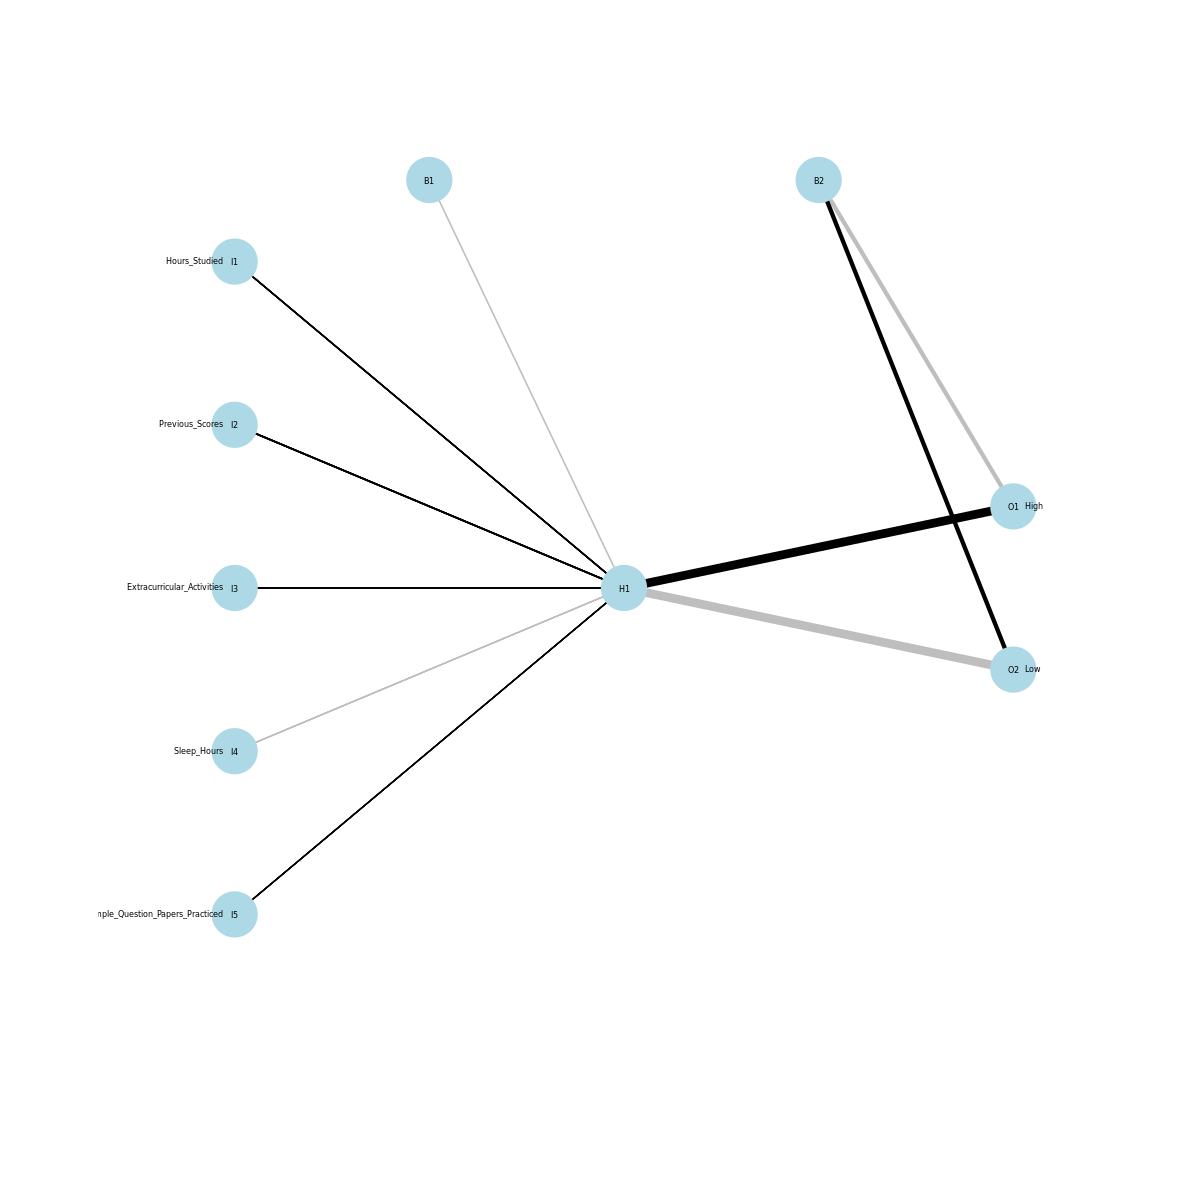

In [20]:
NeuralNetTools::plotnet(nn_single, cex_val = 0.4, line_stag = 0)

### Evaluate model performance

In [21]:
prediction1 <- neuralnet::compute(nn_single, dt_test[,c(1:5)])
prediction1

,Hours_Studied,Previous_Scores,Extracurricular_Activities,Sleep_Hours,Sample_Question_Papers_Practiced
1,0.002742045,1.12749399,1,0.8664615,-1.5984458
1,-1.542071771,0.89685541,1,0.8664615,1.1915890
1,-0.769664863,1.18515364,2,-0.9025493,0.4940803
1,0.388945498,0.60855719,2,-1.4922196,0.8428346
1,-1.542071771,-0.71761464,1,-1.4922196,0.4940803
1,0.388945498,-1.17889180,2,0.8664615,-0.2034284
1,0.775148952,-0.25633748,1,-0.3128791,0.8428346
1,-0.383461409,-0.94825322,1,-0.3128791,1.5403433
1,1.161352406,1.06983435,2,-0.3128791,-1.2496914
1,-0.769664863,-1.52484967,1,-1.4922196,1.5403433


In [22]:
pred_results <- prediction1$net.result
str(pred_results)

 num [1:100, 1:2] 1.00 3.72e-20 1.00 1.00 3.40e-21 ...


In [23]:
pred_results %>% round

1,0
0,1
1,0
1,0
0,1
0,1
0,1
0,1
1,0
0,1
0,1


In [24]:
class_preds <- apply(pred_results, 1, which.min) - 1
class_preds

[1] 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1
 [38] 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1
 [75] 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1

In [25]:
class_test <- dt_test[,High]
class_test

[1] 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1
 [38] 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1
 [75] 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1

In [26]:
table(fitted = class_preds, actual = class_test) %>% 
    caret::confusionMatrix()

Confusion Matrix and Statistics

      actual
fitted  0  1
     0 64  2
     1  4 30
                                         
               Accuracy : 0.94           
                 95% CI : (0.874, 0.9777)
    No Information Rate : 0.68           
    P-Value [Acc > NIR] : 2.654e-10      
                                         
                  Kappa : 0.8644         
                                         
 Mcnemar's Test P-Value : 0.6831         
                                         
            Sensitivity : 0.9412         
            Specificity : 0.9375         
         Pos Pred Value : 0.9697         
         Neg Pred Value : 0.8824         
             Prevalence : 0.6800         
         Detection Rate : 0.6400         
   Detection Prevalence : 0.6600         
      Balanced Accuracy : 0.9393         
                                         
       'Positive' Class : 0              
                                         